# Etapa de EDA.

#### Este proceso lo haremos un poco por encima ya que sabemos lo que nos interesa. el promedio de votos, el titulo y el resumen de la pelicula. ya que con eso podremos preparar nuestro modelo de machine learning. Aun asi, exploremos un poco estos datos

En este archivo crearemos un dataframe al estilo doomies de los generos que poseemos.

Ya que me interesa saber cuales son los generos mas populares.

Importamos nuestras librerias.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

Traemos el dataframe preprocesado.

In [63]:
data = pd.read_csv('data/peliculas_ETL.csv', low_memory=False, index_col='id')
df = data.copy()
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42196 entries, 862 to 461257
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  42196 non-null  object 
 1   budget                 42196 non-null  float64
 2   genres                 42196 non-null  object 
 3   original_language      42196 non-null  object 
 4   overview               42196 non-null  object 
 5   popularity             42196 non-null  float64
 6   production_companies   42196 non-null  object 
 7   production_countries   42196 non-null  object 
 8   release_date           42196 non-null  object 
 9   revenue                42196 non-null  float64
 10  runtime                42196 non-null  float64
 11  spoken_languages       42196 non-null  object 
 12  status                 42196 non-null  object 
 13  tagline                42196 non-null  object 
 14  title                  42196 non-null  object 
 15  vote

Podemos observar que la columna release_date esta de nuevo como tipo object, pero como no nos hara falta, la eliminemos.

In [64]:
df_index = df.reset_index()
df.reset_index(inplace=True)

In [65]:
df.describe()

,id,budget,popularity,revenue,runtime,vote_average,vote_count,release_year,return
count,42196.000000,4.219600e+04,42196.000000,4.219600e+04,42196.000000,42196.000000,42196.000000,42196.000000,4.219600e+04
mean,106669.904896,4.160088e+06,2.914097,1.116670e+07,93.853302,5.631261,109.391720,1991.914399,7.095609e+04
std,111704.740881,1.721499e+07,5.744661,6.377178e+07,37.578123,1.921395,489.341742,23.839319,7.745654e+06
min,2.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1874.000000,-1.000000e+02
25%,25792.000000,0.000000e+00,0.387424,0.000000e+00,85.000000,5.000000,3.000000,1978.000000,0.000000e+00
50%,58390.500000,0.000000e+00,1.136089,0.000000e+00,95.000000,6.000000,10.000000,2001.000000,0.000000e+00
75%,152939.250000,0.000000e+00,3.717885,0.000000e+00,106.000000,6.800000,35.000000,2010.000000,0.000000e+00
max,469172.000000,3.800000e+08,547.488300,2.787965e+09,1256.000000,10.000000,14075.000000,2020.000000,1.239638e+09


Por el momento dejaremos las columnas que nos interesan

In [66]:
df_reducido = df[['belongs_to_collection', 'genres',
       'overview',  'production_companies',
       'production_countries',
         'tagline', 'title',  'director', 'actors_names']].copy()

Comenzemos con un tipo one hot encoding para la columna genres.

In [67]:
#extraemos y eliminamos faltantes
series_genres = pd.DataFrame(df_reducido['genres'])
series_genres.replace('N/D', '[]', inplace=True)
series_genres.head()

,genres
0,"['Animation', 'Comedy', 'Family']"
1,"['Adventure', 'Fantasy', 'Family']"
2,"['Romance', 'Comedy']"
3,"['Comedy', 'Drama', 'Romance']"
4,['Comedy']


In [68]:
#extraemos los generos unicos para usarlos como columnas.
generos_unicos = []
for i in range(0, series_genres.shape[0]):
    fila = series_genres.iloc[i, 0]
    fila = eval(fila)
    for genero in fila:
        if genero not in generos_unicos:
            generos_unicos.append(genero)
print(generos_unicos)
    

['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie']


Creamos una funcion para ingresar los valores en cada fila. esto puede demorar un poco.

In [69]:
diccionario_generos = {}
for genero in generos_unicos:
    diccionario_generos[genero] = []


for i in range(0, series_genres.shape[0]):
    fila = series_genres.iloc[i, 0]
    fila = eval(fila)
    if len(fila) == 0:
        for key in diccionario_generos:
            diccionario_generos[key].append(0)
    else:
        for key in diccionario_generos:
            if key in fila:
                diccionario_generos[key].append(1)
            else:
                diccionario_generos[key].append(0)

generos_dummies = pd.DataFrame(diccionario_generos)
generos_dummies.head(3)

,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,History,Science Fiction,Mystery,War,Foreign,Music,Documentary,Western,TV Movie
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Le agregemos la columna id para luego hacer un merge

In [70]:
df_index = list(df.index)
dicc_index = {'id': df_index}
df_index = pd.DataFrame(dicc_index)
generos_dummies['id'] = df_index
generos_dummies.head(3)

,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,...,History,Science Fiction,Mystery,War,Foreign,Music,Documentary,Western,TV Movie,id
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


Creemos otro dataframe con los valores de los votos para analizar las mejores peliculas votadas por la gente.

In [71]:
df5 = df[['id', 'title','vote_count','vote_average']]
df5.shape

(42196, 4)

In [72]:
df5.describe()

,id,vote_count,vote_average
count,42196.000000,42196.000000,42196.000000
mean,106669.904896,109.391720,5.631261
std,111704.740881,489.341742,1.921395
min,2.000000,0.000000,0.000000
25%,25792.000000,3.000000,5.000000
50%,58390.500000,10.000000,6.000000
75%,152939.250000,35.000000,6.800000
max,469172.000000,14075.000000,10.000000


Eliminemos los valores nulos y analizemos la distribucion

In [73]:
df2 = df5.drop(df5[df5["vote_average"] == 0].index)
df_EDA = df2.drop(df2[df2["vote_count"] == 0].index)
print(df_EDA.shape)
df_EDA.head(5)


(39440, 4)


,id,title,vote_count,vote_average
0,862,Toy Story,5415.0,7.7
1,8844,Jumanji,2413.0,6.9
2,15602,Grumpier Old Men,92.0,6.5
3,31357,Waiting to Exhale,34.0,6.1
4,11862,Father of the Bride Part II,173.0,5.7


Observamos que nos quedan 39440 peliculas, hagamos un pequeño analisis a esto.

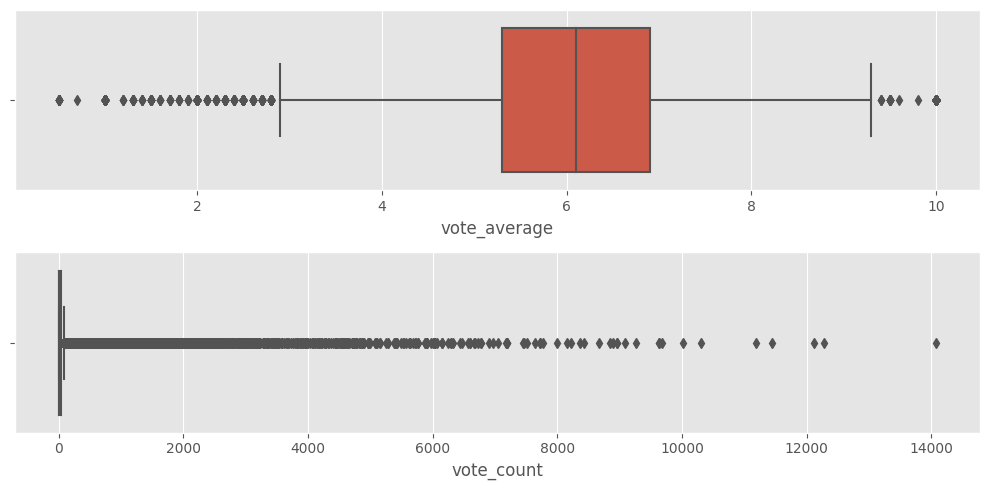

In [74]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
sns.boxplot(x=df_EDA['vote_average'], ax=axs[0])
sns.boxplot(x=df_EDA['vote_count'], ax=axs[1])

plt.tight_layout()
plt.show()

Podemos observar que hay una gran cantidad de peliculas con muy pocas vistas, pongamos un umbral para que sea real.

Chequeemos las peliculas que tienen mas de 500 votos.

In [75]:
df_EDA['vote_count'] = df_EDA['vote_count'].apply(lambda x: x if x > 500 else None)
df_EDA = df_EDA.dropna()
df_EDA.shape

(1888, 4)

Wow!, solo 1888 peliculas tienen mas de 500 votos!, okey veamos cuales son las distribuciones ahora.

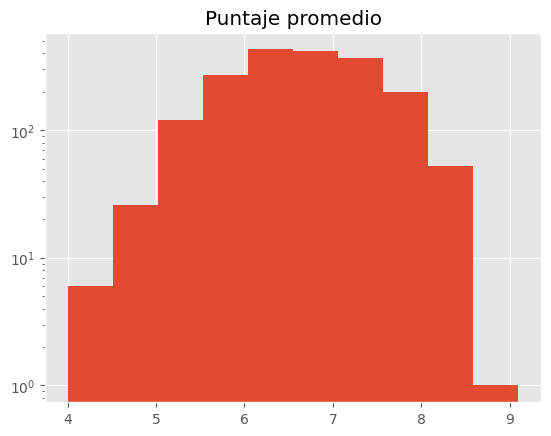

In [76]:
plt.hist(df_EDA['vote_average'], log= True)
plt.title('Puntaje promedio')
plt.show()

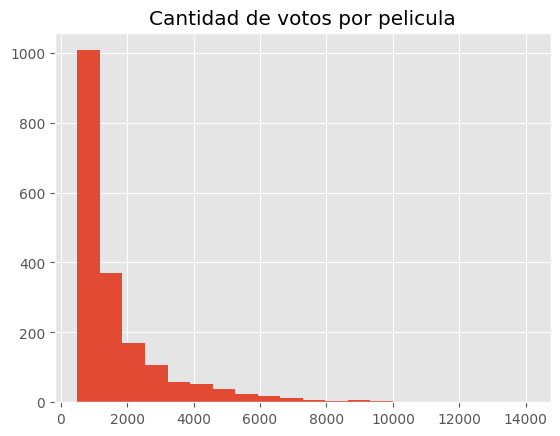

In [77]:
df_EDA['vote_count'].hist(bins=20)
plt.title('Cantidad de votos por pelicula')
plt.show()

Vemos que tienen una distribucion un poco mas legibles, veamos los outliers

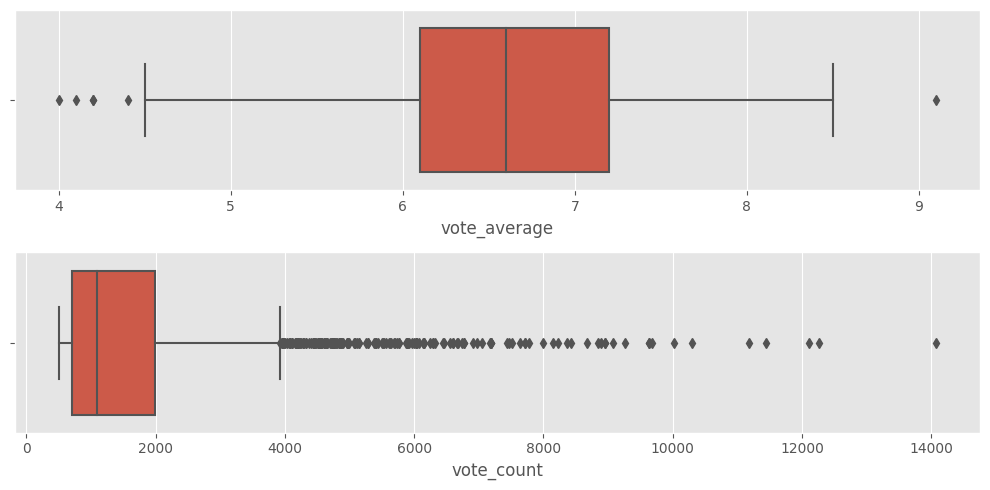

In [78]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
sns.boxplot(x=df_EDA['vote_average'], ax=axs[0])
sns.boxplot(x=df_EDA['vote_count'], ax=axs[1])

plt.tight_layout()
plt.show()

Ahora que mejoramos un poco el estado de nuestro dataset podemos analizar un poco las peliculas.

In [79]:
df_EDA = df_EDA.sort_values(by=['vote_average', 'vote_count'], ascending=False)
print(f'pelicula con mas votos y puntaje: {df_EDA.iloc[0, 1]}')
print(f'pelicula con menos votos y puntaje: {df_EDA.iloc[-1, 1]}')

pelicula con mas votos y puntaje: Dilwale Dulhania Le Jayenge
pelicula con menos votos y puntaje: Jack and Jill


Creemos una variable con los top 10

In [80]:
top_10_df = df_EDA.sort_values(by=['vote_average', 'vote_count'], ascending=False).head(10)

T los grafiquemos

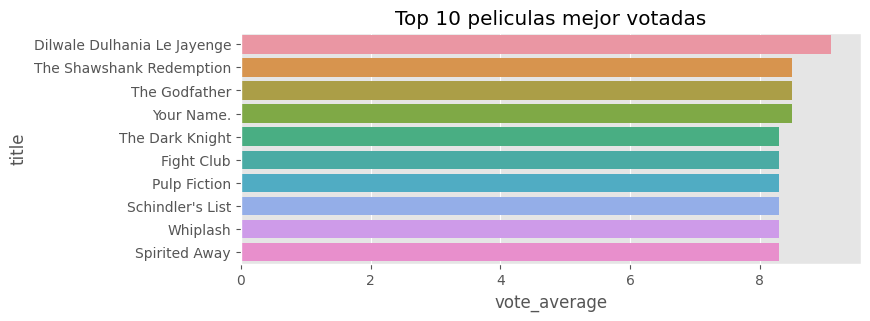

In [81]:
fig = plt.figure(figsize=(8, 3))
sns.barplot(data=top_10_df,y='title', x='vote_average')
plt.title('Top 10 peliculas mejor votadas')
plt.show()

Seria interesante averiguar los 10 generos mas frecuentes, vamos a ello.

In [82]:
df_generos = pd.merge(generos_dummies, df_EDA, how='inner', on='id')
df_generos.shape

(1238, 24)

In [83]:
df_solo_generos = df_generos[['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History',
       'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary',
       'Western', 'TV Movie']].copy()
top_10_generos = df_solo_generos.sum().sort_values(ascending=False)
y = list(top_10_generos.values)
x = list(top_10_generos.index)

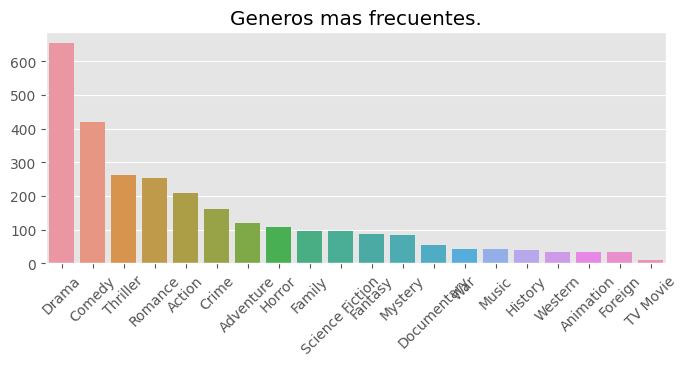

In [84]:
fig = plt.figure(figsize=(8,3))
sns.barplot(y=y, x=x)
plt.title('Generos mas frecuentes.')
plt.xticks(rotation=45)
plt.show()

In [87]:
df_overview = df[['overview', 'id']].copy()
df_ml = pd.merge(df_EDA, df_overview, on='id')
df_ml.shape


(1888, 5)

In [ ]:
df_ml.to_csv('data/df_ml.csv')